# Qiskit Learning Procedure
This notebook provides the `LearningProcedure` and `ProcedureAnalysis` which are used to implement the tomography of a single circuit layer in Qiskit. Eventually, this should be put into the Qiskit Experiments framework.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, PTM
from random import choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
import scipy as sc
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer
from qiskit.providers.aer.noise import NoiseModel, pauli_error

import warnings

warnings.simplefilter('error', sc.optimize.OptimizeWarning)
plt.style.use("ggplot")

In [7]:
class LearningProcedure:
    def __init__(self, layer, inst_map, backend):
        self.layer = layer.copy_empty_like()
        for gate in layer:
            if gate.operation.num_qubits == 2:
                self.layer.append(gate)

        self.backend = backend
        self.n = layer.num_qubits
        self.inst_map = inst_map

        connectivity = backend.coupling_map.graph.subgraph(inst_map)
        self.bases = self.pauli_bases(connectivity)
        self.model_terms = self.get_model_terms(connectivity)


    def pauli_bases(self, connectivity):

        n = self.n
        NUM_BASES = 9

        bases = [['I']*n for i in range(NUM_BASES)]

        for vertex in range(n):
            #copied from Fig. S3 in van den Berg
            orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}
            
            children = connectivity.neighbors(vertex)
            predecessors = [c for c in children if c < vertex]

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    pred, = predecessors
                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    _,bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                case 2:
                    pred0,pred1 = predecessors
                    _,bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))
                    #list out string with permuted values of predecessor 2
                    substr = [p[pred0] for p in bases]
                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        substr = "".join(["XYZ"[perm.index(p)] for p in substr])
                        if substr in orderings:
                            current = orderings[substr] 
                            for i,p in enumerate(current):
                                bases[i][vertex] = p
                            break
                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")

        bases = ["".join(b) for b in bases]
        print("Pauli bases chosen: ", bases)
        return [Pauli(string[::-1]) for string in bases]

    def get_model_terms(self, connectivity):
        n = self.n
        model_terms = set()
        identity = Pauli("I"*n)    
        #get all weight-two paulis on with suport on nieghboring qubits
        for q1,q2 in connectivity.edge_list():
                for p1, p2 in pauli_basis(2, pauli_list = True):
                    pauli = identity.copy()
                    pauli[q1] = p1
                    pauli[q2] = p2
                    model_terms.add(pauli)

        model_terms.remove(identity)
        print("Model terms:", [m.to_label()[::-1] for m in model_terms])

        return list(model_terms)
    
    def instance( 
        self,
        prep_basis : Pauli, 
        meas_basis : Pauli, 
        noise_repetitions : int, 
        transpiled=True):

        n = self.n
        circ = QuantumCircuit(n) #storing the final circuit

        #get preparation ops from desired basis 
        def prep(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit) 
            elif basis.equiv(Pauli("Y")):
                qc.h(qubit)
                qc.s(qubit)

        #apply operators to a quantum circuit to measure in desired pauli basis
        def meas(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit)
            elif basis.equiv(Pauli("Y")):
                qc.sdg(qubit)
                qc.h(qubit)

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def conjugate(pauli):
            return nophase(pauli.evolve(self.layer))

        pauli_frame = Pauli("I"*n)

        #apply the prep and twirling operators to the circuit
        for q,b in enumerate(prep_basis):
            prep(b,q,circ)

        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions):

            twirl = Pauli("".join(choices("IXYZ", k=n)))
            pauli_frame = pauli_frame.compose(twirl)
            pauli_frame = conjugate(pauli_frame) 

            for i,p in enumerate(twirl):
                circ.append(p, [i])

            circ = circ.compose(self.layer)
            circ.barrier()

        #choose sstring of bit flips for readout twirling
        rostring = "".join(choices(['I','X'], k=n))
        for i,p in enumerate(pauli_frame):
            circ.append(p, [i])

        for q,(b,r) in enumerate(zip(meas_basis, rostring)):
            meas(b, q, circ)
            if r == "X":
                circ.x(q)

        circ.measure_all()

        if transpiled:
            circ = transpile(circ, self.backend, inst_map=self.inst_map, optimization_level = 1)

        circ.metadata = {
            "prep_basis":prep_basis,
                "meas_basis":meas_basis, 
                "depth":noise_repetitions, 
                "rostring":rostring[::-1],
                }

        return circ 

    def procedure(
        self,
        depths,
        samples,
        single_samples = None,
        transpiled = True
    ):

        if isinstance(samples, int):
            samples = [samples]*len(depths)
        if not single_samples:
            single_samples = samples[0]

        self.depths = depths
        self.single_samples = single_samples

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def conjugate(pauli):
            return nophase(pauli.evolve(self.layer))

        def weight(pauli):
            return len([p for p in pauli if not p==Pauli("I")])

        #return True if Paulis differ by "I"s only
        def disjoint(pauli1, pauli2):
            return all([p1==p2 or (p1 == Pauli("I") or p2 == Pauli("I")) for p1,p2 in zip(pauli1, pauli2)])

        #return True if pauli requires a degeracy lifting measurement based on the conditions described above
        def is_single(pauli):
            pair = conjugate(pauli)
            return (pauli in self.model_terms and pair in self.model_terms) and pauli != pair

        #find disjoint operators that can be measured simultaneously to find six bases
        pairs = set([frozenset([p,conjugate(p)]) for p in self.model_terms if is_single(p)])
        single_bases = []
        for p1,p2 in pairs:
            for i,pauli in enumerate(single_bases):
                if disjoint(pauli, p1) and disjoint(pauli, p2):
                    single_bases[i] = nophase(pauli.compose(p2))
                    break
            else:
                single_bases.append(p2)

        print("bases for singles: ",single_bases)

        SINGLE = 1
        circuits = []
        bases = self.bases
        total = len(bases)*sum(samples)+len(single_bases)*single_samples

        j=0
        for basis, (d,s) in product(bases, zip(depths,samples)):
            for i in range(s):
                circ = self.instance(basis, basis, d, transpiled)
                circ.metadata["type"] = "double"
                circuits.append(circ)

                j+=1
                print(j,"/",total, end='\r')

        for basis, s in product(single_bases, range(single_samples)):
            circ = self.instance(conjugate(basis),basis,SINGLE, transpiled)
            circ.metadata["type"] = "single"
            circuits.append(circ)

            j+=1
            print(j,"/",total, end='\r')
        
        print("Generated",len(circuits), "circuits")
        return circuits
        

In [8]:
class ProcedureAnalysis:
    def __init__(self, layer, inst_map, depths, single_samples, model_terms):
        self.n = len(inst_map) 
        self.inst_map = inst_map
        self.layer = layer
        
        self.depths = depths
        self.single_samples = single_samples

        self.model_terms = model_terms
        self.noise_model = []
        self.ordered_data = {}

    @classmethod
    def fromExperiment(cls, experiment):
        return cls(
            experiment.layer,
            experiment.inst_map,
            experiment.depths,
            experiment.single_samples,
            experiment.model_terms
        )

    def get_expectation(self, pauli, **metadata):
        estimator = 0
        counts = metadata['counts']
        rostring = metadata['rostring']
        #compute locations of non-idetity terms (reversed indexing)
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            #untwirl the readout
            ro_untwirled = [{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)]
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, ro_untwirled)])
            #update estimator
            estimator += (-1)**sgn*counts[key]

        return estimator/sum(counts.values())

    def get_noise_model(self, basis_dict):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def conjugate(pauli):
            return nophase(pauli.evolve(self.layer))
  
        F1 = []
        F2 = []
        fidelities = []
        for key in self.model_terms:
            F1.append(key)
            fidelities.append(basis_dict[key]['fidelity'])
            if basis_dict[key]["type"] == "pair":
                pair = conjugate(key)
                F2.append(pair)
            else:
                F2.append(key)

        sprod = lambda a,b: int(a.anticommutes(b))
        M1 = [[sprod(a,b) for a in self.model_terms] for b in F1]
        M2 = [[sprod(a,b) for a in self.model_terms] for b in F2]

        if np.linalg.matrix_rank(np.add(M1,M2)) != len(self.model_terms):
            raise Exception("Matrix is not full rank, something went wrong!")

        coeffs,rnorm = nnls(np.add(M1,M2), -np.log(fidelities))

        noise_model = list(zip(coeffs, self.model_terms))

        print("Noise model reconstructed with r-norm", rnorm)

        return noise_model
        

    def analyze(self, results, circuits):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def conjugate(pauli):
            return nophase(pauli.evolve(self.layer))
            
        def simultaneous(pauli1, pauli2):
            return all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(pauli1, pauli2)])\

        def is_single(pauli):
            pair = conjugate(pauli)
            return (pauli in self.model_terms and pair in self.model_terms) and pauli != pair

        def sim_meas(pauli):
            return [term for term in self.model_terms if simultaneous(pauli, term)]

        def all_sim_meas(pauli):
            return [Pauli("".join(p)) for p in product(*zip(pauli.to_label(), "I"*self.n))]

        depths = self.depths
        single_samples = self.single_samples

        #Sort into single and double measurements
        for res,circ in zip(results, circuits):
            circ.metadata["counts"] = res

        singles = []
        doubles = []
        for circ in circuits:
            datum = circ.metadata
            type = datum["type"]
            if type == "single":
                singles.append(datum)
            elif type == "double":
                doubles.append(datum)

        #reorder by measurement basis
        basis_dict = {}
        #improve execution time by storing runs of all_sim_meas for each basis
        sim_measurements = {}
        for datum in doubles:
            #get run data
            basis = datum['prep_basis']
            depth = datum['depth']
            #find simultaneous measurements
            if not basis in sim_measurements:
                sim_measurements[basis] = all_sim_meas(basis)
            #aggregate expectation value data for each simultaneous measurement
            for pauli in sim_measurements[basis]:
                expectation = self.get_expectation(pauli, **datum)
                #set up dictionary
                if not pauli in basis_dict:
                    basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
                #add expectation value to result at depth
                basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
                basis_dict[pauli]["total"][depths.index(depth)] += 1        

        expfit = lambda x,a,b : a*np.exp(x*-b)
        #for each of the simultaneous measurements
        for key in basis_dict.keys():
            for i,d in enumerate(depths):
                #divide by total
                basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
            #try finding exponential fit, default to ideal if no fit found
            try:
                popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
            except:
                popt = 1,0

            #store fidelity and SPAM coefficients
            basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
            basis_dict[key]["SPAM"] = popt[0]

            #record whether measurement appears as a pair or as a single fidelity
            if key != conjugate(key):
                basis_dict[key]["type"] = "pair"
            else:
                basis_dict[key]["type"] = "single"
        
        singles_dict = {} #store results of single measurements
        sim_measurements = {}
        for datum in singles:
            meas_basis = datum['meas_basis']
            prep_basis = datum['prep_basis']
            #find terms that can be measured simultaneously
            if not meas_basis in sim_measurements:
                sim_measurements[meas_basis] = []
                for term in self.model_terms:
                    if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term)) and is_single(term):
                        sim_measurements[meas_basis].append(term)
            #aggregate data together
            for meas in sim_measurements[meas_basis]:
                if meas not in singles_dict:
                    singles_dict[meas] = 0
                expectation = self.get_expectation(meas, **datum)
                #the measurement basis SPAM coefficients are closer because the readout noise, combined
                #with the noise from the last layer, is greater than the state preparation noise
                fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
                singles_dict[meas] += fidelity/single_samples

        #add singles data to basis_dict
        for key in singles_dict.keys():
            basis_dict[key]['fidelity'] = singles_dict[key]
            basis_dict[key]['type'] = "single"
        
        #fit model 
        self.noise_model = self.get_noise_model(basis_dict)
        for coeff, pauli in self.noise_model:
            basis_dict[pauli]["coefficient"] = coeff

        self.ordered_data = basis_dict
        return basis_dict
    
    #graph a subset of the measured expectation values and plot fits
    def graph(self,*paulis):
        expfit = lambda x,a,b : a*np.exp(x*-b)
        colcy = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:olive"])
        for p in paulis:
            c = next(colcy)
            data = self.ordered_data[p]['expectation']
            popt, pcov = curve_fit(expfit, self.depths, data, p0=[.9,.01])
            xrange = np.linspace(0,np.max(self.depths))
            plt.plot(xrange, [expfit(x, *popt) for x in xrange], color=c)
            plt.plot(self.depths, data, color = c, marker="o", linestyle = 'None')
        plt.title("Expectation vs Depth")
        plt.xlabel("Depth")
        plt.ylabel("Fidelity")
        plt.show()

    #display the measured fidelities plotted against the ideal fidelitites
    def display(self,*paulis, factor = 10):
        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        def conjugate(pauli):
            return nophase(pauli.evolve(self.layer))
        basis_dict = self.ordered_data 
        ax = np.arange(len(paulis))
        fidelities = []
        for p in paulis:
            fid = basis_dict[p]['fidelity']
            if(basis_dict[p]['type'] == 'pair'):
                pair = conjugate(p)
                fid = fid**2/basis_dict[pair]['fidelity']
            fidelities.append(fid)
        plt.bar(ax, [10*(1-f) for f in fidelities],color='tab:blue')
        plt.xticks(ax, paulis)
        plt.title("Measured Fidelitites")
        plt.xlabel("Term")
        plt.ylabel(str(factor)+" x (1-f)")
        plt.legend(["Measured", "Ideal"])
        plt.show()

    def display_model(self, *paulis, labels = None):
        if not labels:
            labels = paulis
        ax = np.arange(len(paulis))
        coeffs,_ = zip(*self.noise_model)
        plt.bar(ax, coeffs, color='tab:blue')
        plt.xticks(ax, labels);
        plt.title("Measured Model Terms")
        plt.xlabel("Term")
        plt.ylabel("Coefficient")
        plt.show()

In [9]:
layer = QuantumCircuit(2)
layer.cx(0,1)
backend = FakeVigoV2()
sim = Aer.get_backend("qasm_simulator")
inst_map = [0,1]
tglp = LearningProcedure(layer, inst_map,backend)

Pauli bases chosen:  ['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']
Model terms: ['ZZ', 'YY', 'IZ', 'XZ', 'YI', 'ZY', 'XI', 'IX', 'YZ', 'XY', 'ZX', 'XX', 'YX', 'ZI', 'IY']


In [11]:
from qiskit.providers.aer.noise import pauli_error
from random import random

errorgen = 4
errorops = choices(pauli_basis(2, pauli_list = True), k=errorgen)
errorprobs = [random()*.05/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

In [12]:
real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]

In [13]:
circuits = tglp.procedure([2,4,16, 32], 50,50, transpiled=False)

bases for singles:  [Pauli('ZY'), Pauli('ZI'), Pauli('YZ'), Pauli('ZX'), Pauli('XY'), Pauli('IX')]
Generated 2100 circuits


In [25]:
results = sim.run(circuits, shots=1000, noise_model = noise_model).result().get_counts()

In [76]:
analysis = ProcedureAnalysis.fromExperiment(tglp)
basis_dict = analysis.analyze(results,circuits)

Noise model reconstructed with r-norm 0.004110053867889846


/home/ben/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [62]:
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))

def display(*paulis):
    fidelities = []
    fidelities_calculated = []
    ax = np.arange(len(paulis))
    for p in paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = nophase(p.evolve(layer))
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='tab:blue')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='tab:green')
    plt.xticks(ax, paulis)
    plt.title("Measured vs. ideal fidelities for a CNOT gate")
    plt.xlabel("Pauli term")
    plt.ylabel("10x(1-f)")
    plt.legend(["Measured", "Calculated"])

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


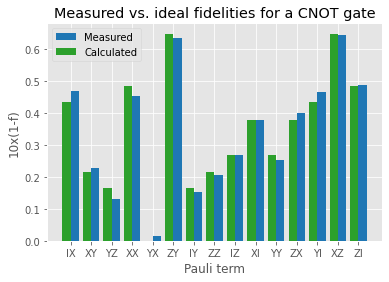

In [63]:
display(*tglp.model_terms)

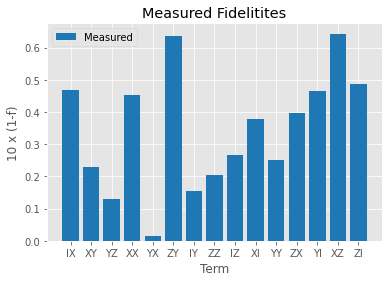

In [77]:
analysis.display(*analysis.model_terms)

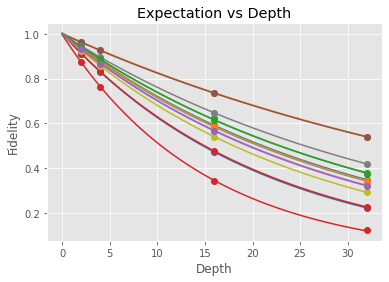

In [78]:
analysis.graph(*analysis.model_terms)

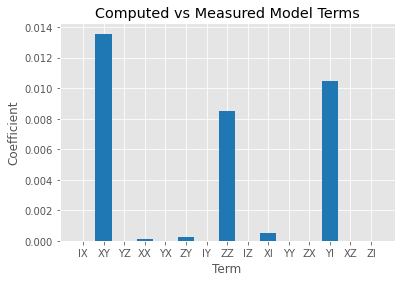

In [80]:
analysis.display_model(*analysis.model_terms)